In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd
import torch

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

print("Dataset config:", cfg.dataset)
print("Audio config:", cfg.audio)

Dataset config: {'name': 'icbhi', 'data_folder': '/home/AIoT04/Datasets/icbhi_dataset', 'cycle_metadata_path': '/home/AIoT04/Datasets/icbhi_dataset/icbhi_metadata.csv', 'class_split': 'lungsound', 'split_strategy': 'official', 'test_fold': 0, 'multi_label': True, 'n_cls': 4, 'weighted_sampler': True, 'batch_size': 16, 'num_workers': 0, 'h': 128, 'w': 1024}
Audio config: {'sample_rate': 16000, 'desired_length': 10.0, 'remove_dc': True, 'normalize': False, 'pad_type': 'repeat', 'use_fade': True, 'fade_samples_ratio': 64, 'n_mels': 128, 'frame_length': 40, 'frame_shift': 10, 'low_freq': 100, 'high_freq': 8000, 'window_type': 'hanning', 'use_energy': False, 'dither': 0.0, 'mel_norm': 'mit', 'resz': 1.0, 'raw_augment': 1, 'wave_aug': [{'type': 'Crop', 'sampling_rate': 16000, 'zone': [0.0, 1.0], 'coverage': 1.0, 'p': 0.0}, {'type': 'Noise', 'color': 'white', 'p': 0.1}, {'type': 'Speed', 'factor': [0.9, 1.1], 'p': 0.1}, {'type': 'Loudness', 'factor': [0.5, 2.0], 'p': 0.1}, {'type': 'VTLP', 's

## Test DataLoaders

### ICBHI Dataloader using only test set as the validation set

In [4]:
# Regular training
from ls.data.dataloaders import build_dataloaders

train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio, use_weighted_sampler=True, normal_weight=0.3)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)

BUILDING DATALOADERS

[1/3] Building training dataset...

[ICBHI] Imputation values:
  Age median: 68.0
  BMI median: 27.4
[ICBHI] Loaded cycle metadata: 6898 rows
[ICBHI] Sites: 7 - {'Al': 0, 'Ar': 1, 'Ll': 2, 'Lr': 3, 'Pl': 4, 'Pr': 5, 'Tc': 6}
[ICBHI] Devices: 4 - {'AKGC417L': 0, 'Litt3200': 1, 'LittC2SE': 2, 'Meditron': 3}


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 4142 cycles from 539 recordings

[ICBHI] Validating dataset...
Dataset validation passed - no NaN/Inf in continuous features

[ICBHI] Dataset: TRAIN
Input spectrogram shape: (997, 128, 1)
Total cycles: 4142

Multi-label distribution:
  Normal (00): 2063 (49.8%)
  Crackle (10): 1215 (29.3%)
  Wheeze (01): 501 (12.1%)
  Both (11): 363 (8.8%)

Continuous feature statistics:
  age: mean=63.27, std=22.63
  bmi: mean=24.89, std=6.76
  duration: mean=2.74, std=1.21


[2/3] Training statistics computed:
  age: mean=63.2696, std=22.6258
  bmi: mean=24.8925, std=6.7583
  duration: mean=2.7372, std=1.2096

[3/3] Building test dataset with training statistics...

[ICBHI] Imputation values:
  Age median: 68.0
  BMI median: 27.4
[ICBHI] Loaded cycle metadata: 6898 rows
[ICBHI] Sites: 7 - {'Al': 0, 'Ar': 1, 'Ll': 2, 'Lr': 3, 'Pl': 4, 'Pr': 5, 'Tc': 6}
[ICBHI] Devices: 4 - {'AKGC417L': 0, 'Litt3200': 1, 'LittC2SE': 2, 'Meditron': 3}


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 2756 cycles from 381 recordings

[ICBHI] Validating dataset...
Dataset validation passed - no NaN/Inf in continuous features

[ICBHI] Dataset: TEST
Input spectrogram shape: (997, 128, 1)
Total cycles: 2756

Multi-label distribution:
  Normal (00): 1579 (57.3%)
  Crackle (10): 649 (23.5%)
  Wheeze (01): 385 (14.0%)
  Both (11): 143 (5.2%)

Continuous feature statistics:
  age: mean=63.27, std=22.63
  bmi: mean=24.89, std=6.76
  duration: mean=2.74, std=1.21


[Sampling] Using weighted sampling...
  Sample weights: min=0.000119, max=0.000675
  Total samples: 4142

[Loaders] Train batches: 258, Test batches: 173



In [5]:
for batch in train_loader:
    print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
    break

torch.Size([16, 1, 128, 1024]) torch.Size([16, 2]) ['130_2p5_Tc_mc_AKGC417L', '172_2b5_Tc_mc_AKGC417L', '186_2b3_Pr_mc_AKGC417L', '162_2b3_Al_mc_AKGC417L', '226_1b1_Pl_sc_LittC2SE', '103_2b2_Ar_mc_LittC2SE', '130_1p3_Pl_mc_AKGC417L', '172_1b4_Pr_mc_AKGC417L', '120_1b1_Pl_sc_Meditron', '162_1b2_Pl_mc_AKGC417L', '135_2b3_Pl_mc_LittC2SE', '107_2b5_Ll_mc_AKGC417L', '158_1p3_Pr_mc_AKGC417L', '141_1b3_Pr_mc_LittC2SE', '158_1p4_Tc_mc_AKGC417L', '172_1b4_Pr_mc_AKGC417L']


In [6]:
batch.keys()

dict_keys(['input_values', 'audio', 'filename', 'cycle_index', 'pid', 'duration', 'start_time', 'end_time', 'site', 'device', 'site_id', 'device_id', 'age', 'bmi', 'm_rest', 'label'])

In [7]:
batch['input_values'][0].shape, batch['label'][0], batch['filename'][0], batch['duration'][0], batch['start_time'][0], batch['end_time'][0], batch['device'][0], batch['device_id'][0], batch['site_id'][0]

(torch.Size([1, 128, 1024]),
 tensor([1., 0.]),
 '130_2p5_Tc_mc_AKGC417L',
 tensor(2.3920, dtype=torch.float64),
 tensor(11.5600, dtype=torch.float64),
 tensor(13.9520, dtype=torch.float64),
 'AKGC417L',
 tensor(0),
 tensor(6))

In [8]:
from collections import Counter
import numpy as np

def inspect_batch_balance(train_loader, n_batches=100):
    pattern_counter = Counter()
    total = 0
    for i, batch in enumerate(train_loader):
        labels = batch["label"].cpu().numpy()
        # For multi-label mode (2 columns)
        if labels.ndim == 2:
            patterns = [tuple(v) for v in labels]
        else:
            patterns = [int(v) for v in labels]
        pattern_counter.update(patterns)
        total += len(patterns)
        if i >= n_batches:
            break

    print(f"\nChecked {total} samples from {n_batches} batches")
    for pat, c in sorted(pattern_counter.items()):
        print(f"Pattern {pat}: {c} ({100*c/total:.1f}%)")

In [9]:
inspect_batch_balance(train_loader, n_batches=100)


Checked 1616 samples from 100 batches
Pattern (np.float32(0.0), np.float32(0.0)): 420 (26.0%)
Pattern (np.float32(0.0), np.float32(1.0)): 365 (22.6%)
Pattern (np.float32(1.0), np.float32(0.0)): 440 (27.2%)
Pattern (np.float32(1.0), np.float32(1.0)): 391 (24.2%)


In [10]:
def tensors_equal(a, b, atol=1e-6, rtol=1e-5):
    return torch.allclose(a, b, atol=atol, rtol=rtol)

Inspecting sample index 3 in the batch
Keys: dict_keys(['input_values', 'audio', 'filename', 'cycle_index', 'pid', 'duration', 'start_time', 'end_time', 'site', 'device', 'site_id', 'device_id', 'age', 'bmi', 'm_rest', 'label'])
Filename: 162_2b3_Al_mc_AKGC417L
Cycle index: tensor(3)
Label: tensor([0., 0.])
Duration: tensor(1.8700, dtype=torch.float64)
Start-End: tensor(17.1200, dtype=torch.float64) - tensor(18.9900, dtype=torch.float64)
Crackle/Wheeze: tensor(0.) tensor(0.)
Waveform shape: torch.Size([1, 160000])
Mel image shape: torch.Size([1, 128, 1024])


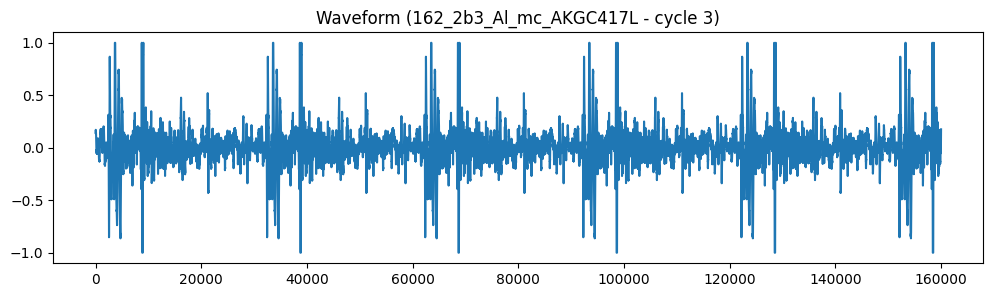

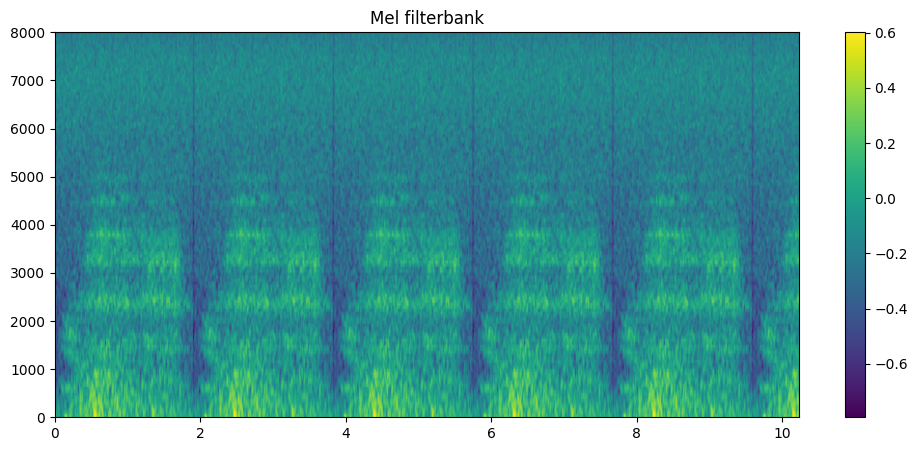

In [11]:
# --- Inspect one sample ---
idx = torch.randint(cfg.dataset.batch_size, (1,)).item()
print(f"Inspecting sample index {idx} in the batch")
print("Keys:", batch.keys())
print("Filename:", batch["filename"][idx])
print("Cycle index:", batch["cycle_index"][idx])
print("Label:", batch["label"][idx])
print("Duration:", batch["duration"][idx])
print("Start-End:", batch["start_time"][idx], "-", batch["end_time"][idx])
print("Crackle/Wheeze:", batch["label"][idx][0], batch["label"][idx][1])
# print(sample["aug_audio"].shape, sample["aug_fbank"].shape, sample["audio"].shape, sample["fbank"].shape)
print("Waveform shape:", batch["audio"][idx].shape)
print("Mel image shape:", batch["input_values"][idx].shape)
# print(f"Waveform augmented: {not tensors_equal(batch['audio'][idx].view(-1), batch['aug_audio'][idx].view(-1))}")
# print(f"Mel augmented: {not tensors_equal(batch['fbank'][idx].view(-1), batch['aug_fbank'][idx].view(-1))}")

# --- 4. Plot waveform ---
waveform = batch["audio"][idx].squeeze().numpy()
plt.figure(figsize=(12, 3))
plt.plot(waveform)
plt.title(f"Waveform ({batch['filename'][idx]} - cycle {batch['cycle_index'][idx]})")
plt.show()

# --- 5. Plot mel spectrogram ---
mel = batch["input_values"][idx].squeeze(0)  # [freq, time] for imshow
freq_axis = np.linspace(0, cfg.audio.sample_rate // 2, mel.shape[0])
time_axis = np.arange(mel.shape[1]) * cfg.audio.frame_shift / 1000  # in seconds
plt.figure(figsize=(12, 5))
plt.imshow(mel, origin="lower", aspect="auto", extent=[0, time_axis[-1], 0, freq_axis[-1]], cmap="viridis")
plt.title("Mel filterbank")
plt.colorbar()
plt.show()

ipd.Audio(waveform, rate=cfg.audio.sample_rate)  # listen to the sound

In [15]:
from ls.data.dataloaders import compute_and_cache_stats

mean, std = compute_and_cache_stats(
    train_loader.dataset, cache_file="../train_stats.json", batch_size=cfg.dataset.batch_size,
    num_workers=cfg.dataset.num_workers
)
print(f"Dataset mean: {mean:.4f}, std: {std:.4f}")

[Stats] Computing dataset-wide mean/std for fbank features...


Computing stats:   0%|          | 0/259 [00:00<?, ?it/s]

Computing stats: 100%|██████████| 259/259 [00:38<00:00,  6.66it/s]

[Stats] Cached mean=-0.3438, std=0.3812 to ../train_stats.json
Dataset mean: -0.3438, std: 0.3812


## Stratified Grouped KFold Dataloader

In [16]:
from ls.data.dataloaders import build_train_val_kfold

In [17]:
# Or: k-fold CV on train set
folds, test_loader = build_train_val_kfold(
    cfg.dataset, cfg.audio, n_splits=5, max_retries=50, seed=cfg.seed
)


BUILDING 5-FOLD CROSS-VALIDATION

[1/2] Loading full training set...
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)

[ICBHI] Imputation values:
  Age median: 68.0
  BMI median: 27.4
[ICBHI] Loaded cycle metadata: 6898 rows
[ICBHI] Sites: 7 - {'Al': 0, 'Ar': 1, 'Ll': 2, 'Lr': 3, 'Pl': 4, 'Pr': 5, 'Tc': 6}
[ICBHI] Devices: 4 - {'AKGC417L': 0, 'Litt3200': 1, 'LittC2SE': 2, 'Meditron': 3}


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 4142 cycles from 539 recordings

[ICBHI] Validating dataset...
Dataset validation passed - no NaN/Inf in continuous features

[ICBHI] Dataset: TRAIN
Input spectrogram shape: (997, 128, 1)
Total cycles: 4142

Multi-label distribution:
  Normal (00): 2063 (49.8%)
  Crackle (10): 1215 (29.3%)
  Wheeze (01): 501 (12.1%)
  Both (11): 363 (8.8%)

Continuous feature statistics:
  age: mean=63.27, std=22.63
  bmi: mean=24.89, std=6.76
  duration: mean=2.74, std=1.21


[2/2] Loading test set...
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)

[ICBHI] Imputation values:
  Age median: 68.0
  BMI median: 27.4
[ICBHI] Loaded cycle metadata: 6898 rows
[ICBHI] Sites: 7 - {'Al': 0, 'Ar': 1, 'Ll': 2, 'Lr': 3, 'Pl': 4, 'Pr': 5, 'Tc': 6}
[ICBHI] Devices: 4 - {'AKGC417L': 0, 'Litt3200': 1, 'LittC2SE': 2, 'Meditron': 3}


/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/storage/data/iotlab/AIoT/konto/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https:/

[ICBHI] Extracted 2756 cycles from 381 recordings

[ICBHI] Validating dataset...
Dataset validation passed - no NaN/Inf in continuous features

[ICBHI] Dataset: TEST
Input spectrogram shape: (997, 128, 1)
Total cycles: 2756

Multi-label distribution:
  Normal (00): 1579 (57.3%)
  Crackle (10): 649 (23.5%)
  Wheeze (01): 385 (14.0%)
  Both (11): 143 (5.2%)

Continuous feature statistics:
  age: mean=63.27, std=22.63
  bmi: mean=24.89, std=6.76
  duration: mean=2.74, std=1.21


[K-Fold] Creating 5 folds with patient-level splitting...
  Total samples: 4142
  Unique patients: 79
  Classes: 4

  Fold 1/5 (attempt 1):
    Train: 3174 samples, Val: 968 samples
    Train patients: 63
    Val patients: 16
    Class distribution:
      Class 0: train=1512, val=551
      Class 1: train=367, val=134
      Class 2: train=1042, val=173
      Class 3: train=253, val=110

  Fold 2/5 (attempt 1):
    Train: 3697 samples, Val: 445 samples
    Train patients: 68
    Val patients: 11
    Class distributi

In [18]:
for i, (train_loader, val_loader) in enumerate(folds):
    # print(f"Training fold {i+1}")
    for batch in train_loader:
        # Process each batch
        print(batch["input_values"].shape, batch["label"].shape, batch["filename"])
        break

torch.Size([16, 1, 128, 1024]) torch.Size([16, 2]) ['138_2p2_Lr_mc_AKGC417L', '166_1p1_Pl_sc_Meditron', '193_1b4_Lr_mc_AKGC417L', '132_2b2_Lr_mc_LittC2SE', '130_2b2_Al_mc_AKGC417L', '218_1b1_Ar_sc_Meditron', '112_1p1_Pr_sc_Litt3200', '121_1p1_Tc_sc_Meditron', '154_1b3_Ar_mc_AKGC417L', '112_1b1_Lr_sc_Meditron', '159_1b1_Pr_sc_Meditron', '159_1b1_Al_sc_Meditron', '166_1p1_Pr_sc_Meditron', '166_1p1_Pr_sc_Meditron', '130_2b3_Lr_mc_AKGC417L', '220_1b2_Al_mc_LittC2SE']
torch.Size([16, 1, 128, 1024]) torch.Size([16, 2]) ['203_1p3_Ar_mc_AKGC417L', '130_2b3_Ll_mc_AKGC417L', '157_1b1_Al_sc_Meditron', '191_2b2_Tc_mc_LittC2SE', '162_2b4_Lr_mc_AKGC417L', '135_2b2_Tc_mc_LittC2SE', '162_2b3_Pl_mc_AKGC417L', '215_1b2_Ar_sc_Meditron', '135_2b1_Al_mc_LittC2SE', '130_1p4_Pr_mc_AKGC417L', '135_2b1_Pl_mc_LittC2SE', '188_1b1_Pl_sc_Meditron', '172_1b4_Lr_mc_AKGC417L', '158_1p4_Tc_mc_AKGC417L', '213_1p3_Al_mc_AKGC417L', '188_1b1_Al_sc_Meditron']
torch.Size([16, 1, 128, 1024]) torch.Size([16, 2]) ['218_1b1_Lr_